In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('SolarPrediction.csv')

df['Data'] = pd.to_datetime(df['Data'])
# Convert the 'Time' column to datetime
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
df = df.sort_values(by=['Data', 'Time'])

df['hour'] = df['Time'].dt.hour
df['month'] = df['Data'].dt.month
df['day_of_week'] = df['Data'].dt.dayofweek

df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,hour,month,day_of_week
7416,1472724008,2016-09-01,1900-01-01 00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,0,9,3
7415,1472724310,2016-09-01,1900-01-01 00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,0,9,3
7414,1472725206,2016-09-01,1900-01-01 00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,0,9,3
7413,1472725505,2016-09-01,1900-01-01 00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,0,9,3
7412,1472725809,2016-09-01,1900-01-01 00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,0,9,3


In [45]:
df.month.unique()

array([ 9, 10, 11, 12])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32686 entries, 7416 to 24522
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   UNIXTime                32686 non-null  int64         
 1   Data                    32686 non-null  datetime64[ns]
 2   Time                    32686 non-null  datetime64[ns]
 3   Radiation               32686 non-null  float64       
 4   Temperature             32686 non-null  int64         
 5   Pressure                32686 non-null  float64       
 6   Humidity                32686 non-null  int64         
 7   WindDirection(Degrees)  32686 non-null  float64       
 8   Speed                   32686 non-null  float64       
 9   TimeSunRise             32686 non-null  object        
 10  TimeSunSet              32686 non-null  object        
 11  hour                    32686 non-null  int64         
 12  month                   32686 non-null  int

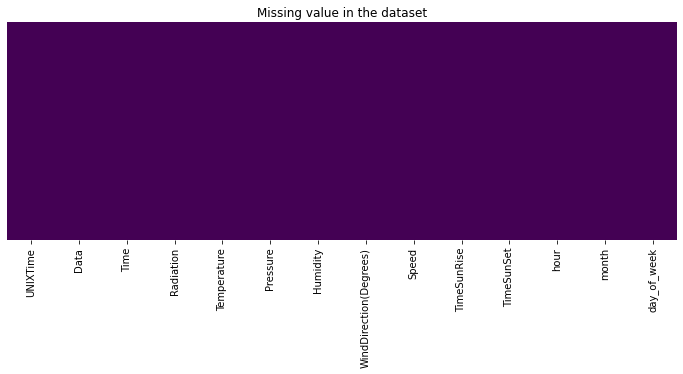

In [5]:
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

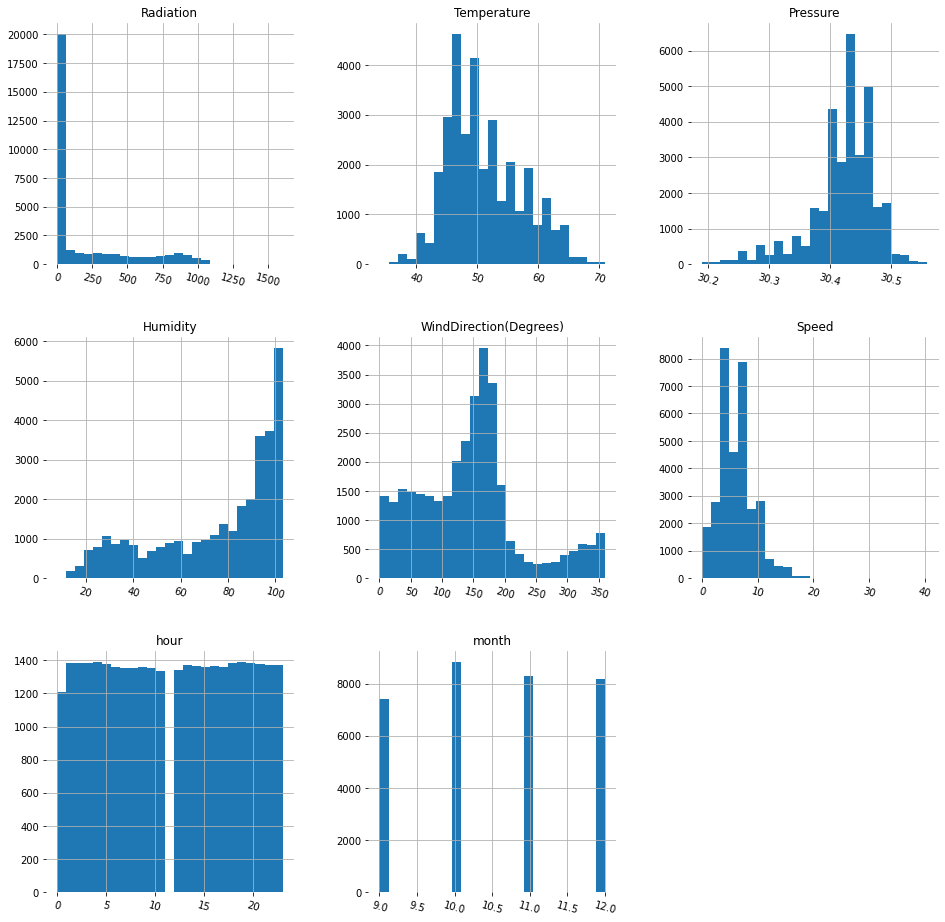

In [27]:
df1=df[['Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'hour', 'month']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

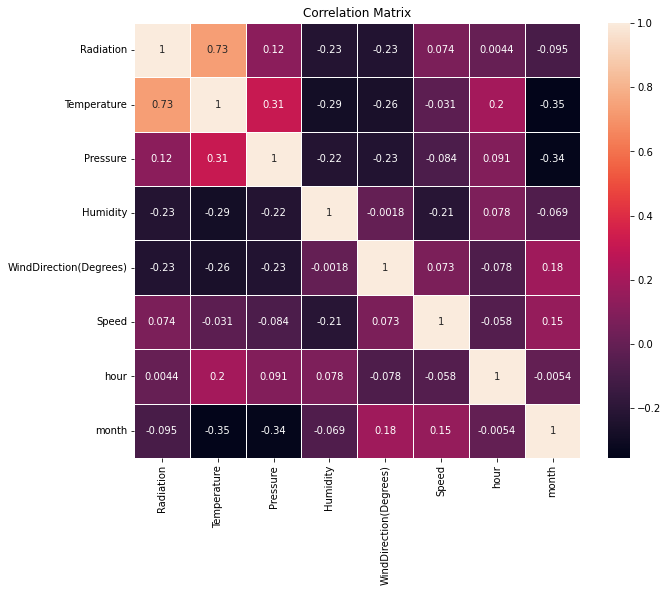

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(df1.corr(), annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Промежуточные выводы
#### 1. Наблюдается положительная корреляция  между температурой и радиацией (0,73). Рост температуры соответсвует росту радиации
#### 2. Отрицательная радиация между радиацией и влажностью(-0,23), т.е. при снижении влажности радиация растет
#### 3. Отрицательная радиация между радиацией и направлением ветра(-0,23), т.е. возможно при определенном направлении ветра радиация снижается (может приносит облака)

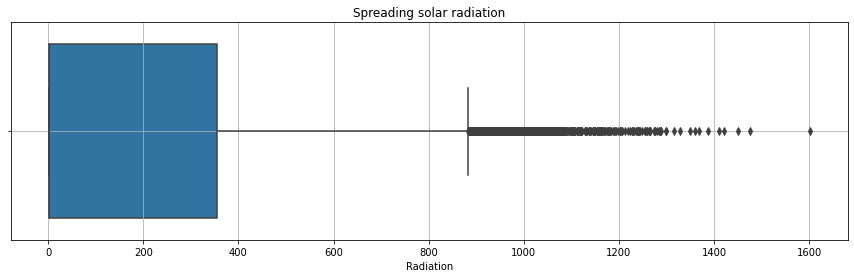

In [29]:
fig= plt.figure(figsize=(15, 4))
boxplot= sns.boxplot(data=df, x='Radiation');
boxplot.set_title('Spreading solar radiation')
boxplot.grid();

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


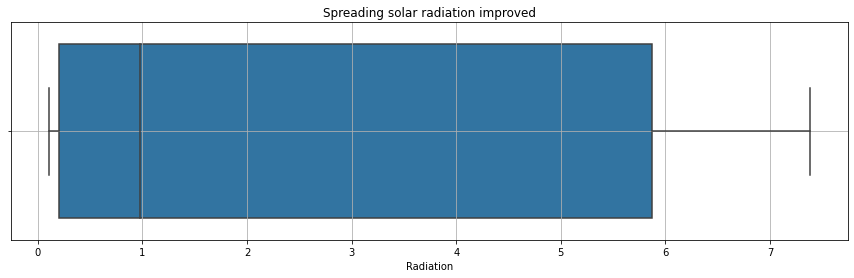

In [30]:
log_target = np.log(df['Radiation'])
fig= plt.figure(figsize=(15, 4))
boxplot= sns.boxplot(log_target, orient='h');
boxplot.set_title('Spreading solar radiation improved')
boxplot.grid();

In [33]:
X = df[['Temperature', 'Pressure','Humidity', 'WindDirection(Degrees)', 'Speed', 'hour', 'month', 'day_of_week']]
#y = df['Radiation']
y = log_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X[2:3]

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,hour,month,day_of_week
7414,51,30.43,103,142.04,7.87,0,9,3


In [13]:
sts = StandardScaler()
X_train = sts.fit_transform(X_train)
X_test = sts.transform(X_test)

In [14]:
from sklearn.linear_model import LinearRegression 
lreg = LinearRegression()
params = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(estimator=lreg, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model_lreg = grid_search.best_estimator_
y_pred = best_model_lreg.predict(X_test)
LinearRegression_mse = mean_squared_error(y_test, y_pred)
print("LinearRegression_mse: ", LinearRegression_mse)

LinearRegression_mse:  2.9053922776063548


In [15]:
def predict_solrad_lreg(data):
    print(data)
    data = sts.transform(data)
    predict = best_model_lreg.predict(data)
    print(predict)
    return np.exp(predict)
print(predict_solrad_lreg(X[2:3]))

      Temperature  Pressure  Humidity  WindDirection(Degrees)  Speed  hour  \
7414           51     30.43       103                  142.04   7.87     0   

      month  day_of_week  
7414      9            3  
[3.10220898]
[22.24704024]


In [16]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rfr, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
RandomForestRegressor_mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)

RandomForestRegressor_mse:  0.1297008209039919


In [17]:
RandomForestRegressor_best_params = grid_search.best_params_
print("RandomForestRegressor_best_params: ", RandomForestRegressor_best_params)

RandomForestRegressor_best_params:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [18]:
def predict_solrad_rfr(data):
    print(data)
    data = sts.transform(data)
    predict = best_model.predict(data)
    print(predict)
    return np.exp(predict)
print(predict_solrad_rfr(X[2:3]))

      Temperature  Pressure  Humidity  WindDirection(Degrees)  Speed  hour  \
7414           51     30.43       103                  142.04   7.87     0   

      month  day_of_week  
7414      9            3  
[0.82921505]
[2.29151931]


In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 10]
}
grid_search = GridSearchCV(estimator=gbr, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model_gbr = grid_search.best_estimator_
y_pred = best_model_gbr.predict(X_test)
GradientBoostingRegressor_mse = mean_squared_error(y_test, y_pred)
print("GradientBoostingRegressor_mse: ", GradientBoostingRegressor_mse)

GradientBoostingRegressor_mse:  0.13476550395973916


In [20]:
GradientBoostingRegressor_best_params = grid_search.best_params_
print("GradientBoostingRegressor_best_params: ", GradientBoostingRegressor_best_params)

GradientBoostingRegressor_best_params:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


In [21]:
def predict_solrad_gbr(data):
    print(data)
    data = sts.transform(data)
    predict = best_model_gbr.predict(data)
    print(predict)
    return np.exp(predict)
print(predict_solrad_gbr(X[2:3]))

      Temperature  Pressure  Humidity  WindDirection(Degrees)  Speed  hour  \
7414           51     30.43       103                  142.04   7.87     0   

      month  day_of_week  
7414      9            3  
[0.79201595]
[2.20784284]


In [43]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(silent=True)
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'subsample': [1.0],
    'colsample_bylevel': [1.0],
    'reg_lambda': [3.0]
}
grid_search = GridSearchCV(estimator=cbr, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_cbr = grid_search.best_estimator_
y_pred = best_cbr.predict(X_test)
CatBoostRegressor_best_params = grid_search.best_params_
print("CatBoostRegressor_best_params: ", CatBoostRegressor_best_params)
CatBoostRegressor_mse = mean_squared_error(y_test, y_pred)
print("CatBoostRegressor_mse: ", CatBoostRegressor_mse)

CatBoostRegressor_best_params:  {'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_lambda': 3.0, 'subsample': 1.0}
CatBoostRegressor_mse:  0.16233207304699945


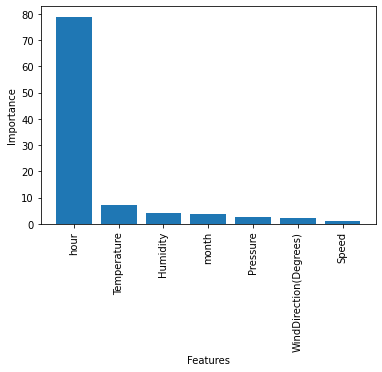

In [41]:
feature_imp = best_cbr.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_imp))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_feature_importances)

plt.bar(features, importances)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [77]:
def predict_solrad_cbr(data):
    print(data)
    data = sts.transform(data)
    predict = best_cbr.predict(data)
    prediction = np.exp(predict)
    print(prediction)
    return prediction
results = predict_solrad_cbr(X[3:4])

      Temperature  Pressure  Humidity  WindDirection(Degrees)  Speed  hour  \
7413           51     30.43       103                  144.12   18.0     0   

      month  day_of_week  
7413      9            3  
[2.76265584]


Mean Squared Error (MSE): 0.16233207304699945
R-squared (R2): 0.9786330240933773


Text(0, 0.5, 'Predictions')

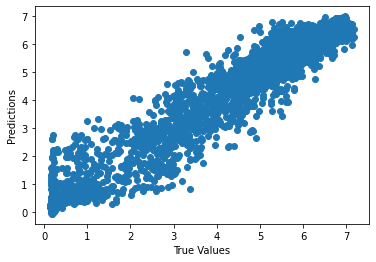

In [46]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

# Optionally, you can plot the predicted values against the true values for visual inspection
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
